## Проект по Python: анализ данных с сайта last.fm
### Автор: Михаил Папоротский

Уже почти девять лет я веду аккаунт на сайте https://www.last.fm/. Это сайт, который позволяет сохранять информацию о прослушанной музыке. Он подключается к приложению, через которое пользователь слушает музыку, и собирает данные о каждом отдельном прослушивании того или иного трека. Сайт сохраняет информацию о дате и времени прослушивания, а также о названии трека, альбома и исполнителя. Одно уникальное прослушивание на сайте называется «скробблом» (scrobble). 

За то время, что я пользуюсь last.fm, я накопил свыше 192 тыс. скробблов. Для меня этот сайт очень важен, потому что он позволяет посмотреть мою музыкальную статистику (например, какие альбомы я слушал больше всего в 2021 году) или посмотреть, что я слушал в определенный день в определенное время. 

Сайт https://lastfm.ghan.nl/export/ позволяет выкачать данные с last.fm в формате JSON. Я подумал о том, что было бы интересно в качестве данных для проекта использовать мою собственную историю прослушивания музыки. 

### Загрузка данных

Загрузим данные в Python. Сайт https://lastfm.ghan.nl/export/ выкачивает их по страницам, поэтому после загрузки данных нужно взять данные с каждой страницы и положить скробблы в общий список.

In [1]:
import json

with open('lastfm_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

all_scrobbles = []

for i, page in enumerate(data):
    scrobbles = page['track']
    for scrobble in scrobbles:
        all_scrobbles.append(scrobble)

print(f'Всего скробблов: {len(all_scrobbles)}') #посмотрим, сколько скробблов содержится в наших данных

Всего скробблов: 192889


### Классы и методы
#### Классы

В моем проекте будет четыре класса: Artist, Album, Track, Scrobble.

* Для класса Artist требуется название исполнителя
* Для класса Album требуется название альбома, а также он будет ссылаться на элемент класса Artist.
* Для класса Track требуется название трека, а также он будет ссылаться на элементы классов Artist и Album
* Для класса Scrobble требуется дата и время прослушивания, а также он будет ссылаться на элементы классов Artist, Album и Track.

В первых трех классах также будет переменная scrobbles_amount, которая будет указывать на количество скробблов, относящихся к данному исполнителю/альбому/треку. Все элементы классов будут уникальными: например, два разных прослушивания трека "Creep" группы Radiohead с альбома "Pablo Honey" будут ссылаться на один элемент класса Track, один элемент класса Album и один элемент класса Artist. 

#### Методы
Я переопределил следующие методы:
* **\_\_new\_\_** — переопределение данного метода мне было необходимо для подсчета количества скробблов у каждого трека/альбома/исполнителя.
* **\_\_eq\_\_** — класс Artists сравнивается только по названию исполнителя; класс Album сравнивается по названию альбома и по исполнителю; класс Track сравнивается по названию трека, а также по альбому и исполнителю; класс Scrobble сравнивается по дате, треку, альбому и исполнителю.
* **\_\_str\_\_** и **\_\_repr\_\_** — я переопределил эти методы для того, чтобы объекты было проще читать при их вызове (см. ниже).
* **\_\_add\_\_** — я переопределил этот метод для классов Track, Album и Artist. Теперь он позволяет объединить два трека/альбома/исполнителя таким образом, что у них складываются скробблы, а ссылки на оба объекта в других объектах переоформляются на объединенный объект. Пользователю предлагается выбрать название нового объекта из двух старых.

Помимо вспомогательных методов, которые помогают работать с вышеперечисленными переопределенными методами, я также написал метод **get_by_name()** для трека, альбома и исполнителя, который позволяет найти объект по его названию (см. ниже).

#### Класс Artist

In [2]:
class Artist:
    _artists = {}  #словарь, в котором будут содержаться все исполнители
    
    def __new__(cls, name: str):

        #если исполнитель уже есть в словаре, то просто добавляем ему скроббл
        if name in cls._artists: 
            artist = cls._artists[name]
            artist.scrobbles_amount += 1
            return artist

        #если исполнитель новый, то создаем его
        else:
            artist = super().__new__(cls)
            cls._artists[name] = artist
            return artist
    
    def __init__(self, name: str):
        if hasattr(self, 'created'): 
            return 
            # это нужно для подсчета скробблов; 
            # если этот элемент класса уже создан, то его повторная инициализация сбрасывала бы счетчик скробблов
            
        self.name = name
        self.scrobbles_amount = 1
        self.created = True
    
    def __eq__(self, other): #переопределяем __eq__: проверяем по имени исполнителя
        if not isinstance(other, Artist):
            return False
        return self.name == other.name 
    
    def __str__(self):
        return f"{self.name}"
    
    def __repr__(self):
        return f"Artist('{self.name}', scrobbles: {self.scrobbles_amount})"
    
    def __add__(self, other): 
        # переопределяем метод __add__
        # идея в том, чтобы пользователь мог объединить двух исполнитель так, 
        # чтобы вместо них обоих появился новый исполнитель с выбранным именем и объединенным количеством скробблов
        if not isinstance(other, Artist):
            raise TypeError("Можно объединять только объекты Artist")
        
        print(f"\nОбъединение артистов:")
        print(f"1. {self.name} (скробблов: {self.scrobbles_amount})")
        print(f"2. {other.name} (скробблов: {other.scrobbles_amount})")
        
        while True:
            choice = input(f"\nВыберите имя для объединенного артиста. Введите 1 или 2: ").strip()
            
            if choice == "1":
                new_name = self.name
                break
            elif choice == "2":
                new_name = other.name
                break
                
            else:
                print("Пожалуйста, введите 1 или 2.")
                
        merged_artist = Artist._merge_artists(self, other, new_name) #для объединения исполнителей используем классовый метод, описанный ниже
        
        return merged_artist
    
    @classmethod
    def _merge_artists(cls, artist1, artist2, new_name):

        print(f"\nОбъединяем исполнитео '{artist1.name}' и '{artist2.name}' в '{new_name}'...")
        
        #создаем нового исполнителя
        merged_artist = cls._create_merged_artist(new_name, artist1.scrobbles_amount + artist2.scrobbles_amount)
        
        #обновляем альбомы, треки и скробблы, которые ссылались на старых исполнителей
        Album._update_artist_references(artist1, artist2, merged_artist)
        Track._update_artist_references(artist1, artist2, merged_artist)
        Scrobble._update_artist_references(artist1, artist2, merged_artist)
        
        #удаляем старых исполнителей
        cls._remove_artist(artist1)
        cls._remove_artist(artist2)

        #выводим информацию для пользователя
        print(f"Объединение исполнителей завершено!")
        print(f"Новый исполнитель: {merged_artist}, количество скробблов: {merged_artist.scrobbles_amount}")
        
        return merged_artist
    
    @classmethod
    def _create_merged_artist(cls, name, scrobbles_amount):
        #удаляем исполнителя из словаря
        cls._artists.pop(name, None)
        
        #создаем нового исполнителя 
        merged_artist = super(Artist, cls).__new__(cls)
        cls._artists[name] = merged_artist
        
        merged_artist.name = name
        merged_artist.scrobbles_amount = scrobbles_amount
        merged_artist.initialized = True
        
        return merged_artist
    
    @classmethod
    def _remove_artist(cls, artist):
        if artist.name in cls._artists and cls._artists[artist.name] is artist:
            del cls._artists[artist.name]
    
    @classmethod
    def get_by_name(cls, name: str):
        #напишем метод, который позволит проще вызывать исполнителя по названию
        #например, Artist.get_by_name('radiohead') вызовет объект Radiohead
        
        name_lower = name.lower()
    
        for artist_name, artist in cls._artists.items():
            if artist_name.lower() == name_lower:
                return artist
                
        print(f'Нет исполнителя с именем {name}!')
        return None
        
    
    @classmethod
    def get_all_artists(cls):
        #метод, который позволяет получить список всех исполнителей
        return list(cls._artists.values())


#### Класс Album

In [3]:
from typing import Optional

class Album:
    _albums = {}
    
    def __new__(cls, name: str, artist: Artist):

        if not name or name is None or name == '': #в last.fm могут попадаться скробблы без альбомов, в таких случаях не создаем альбом
            return None
            
        artist_name = artist.name
        key = (name, artist_name) #делаем ключ в словаре из названия альбома и его исполнителя
        
        if key in cls._albums:
            album = cls._albums[key]
            album.scrobbles_amount += 1
            return album
            
        else:
            instance = super().__new__(cls)
            cls._albums[key] = instance
            return instance
    
    def __init__(self, name: str, artist: Artist): 
        
        if hasattr(self, 'initialized'):
            return
            
        self.name = name
        self.artist = artist
        self.scrobbles_amount = 1
        self.initialized = True
    
    def __eq__(self, other):
        
        if not isinstance(other, Album):
            return False
            
        #проверяем равенство альбомов и по названию, и по исполнителю, к которому они относятся
        return self.name == other.name and self.artist == other.artist 
        
    def __str__(self):
        artist_name = str(self.artist)
        return f"{self.name} ({artist_name})"
    
    def __repr__(self):
        artist_name = self.artist.name
        return f"Album('{self.name}', artist: {artist_name}, scrobbles: {self.scrobbles_amount})"
    
    def __add__(self, other):
        if not isinstance(other, Album):
            raise TypeError("Можно объединять только объекты Album")
        
        #проверяем, что у альбомов одинаковые исполнители
        if self.artist != other.artist:
            raise ValueError(f"Нельзя объединять альбомы разных исполнителей: {self} и {other}")
        
        print(f"\nОбъединение альбомов исполнителя '{self.artist}':")
        print(f"1. {self.name} (скробблов: {self.scrobbles_amount})")
        print(f"2. {other.name} (скробблов: {other.scrobbles_amount})")
        
        while True:
            choice = input(f"\nВыберите имя для объединенного альбома. Введите 1 или 2: ").strip()
            
            if choice == "1":
                new_name = self.name
                new_artist = self.artist
                break
            elif choice == "2":
                new_name = other.name
                new_artist = other.artist
                break
            else:
                print("Пожалуйста, введите 1 или 2.")
        
        merged_album = Album._merge_albums(self, other, new_name, new_artist)
        
        return merged_album
    
    @classmethod
    def _merge_albums(cls, album1, album2, new_name, new_artist):
        
        print(f"\nОбъединяем альбомы '{album1.name}' и '{album2.name}' в '{new_name}'...")
        
        #создаем новый альбом с новыми данными
        merged_album = cls._create_merged_album(new_name, new_artist, 
                                               album1.scrobbles_amount + album2.scrobbles_amount)
        
        #обновляем все треки и скробблы, которые ссылались на старые альбомы
        Track._update_album_references(album1, album2, merged_album)
        Scrobble._update_album_references(album1, album2, merged_album)
        
        #удаляем старые альбомы
        cls._remove_album(album1)
        cls._remove_album(album2)

        #выводим информацию для пользователя
        print(f"Объединение альбомов завершено!")
        print(f"Новый альбом: {merged_album}, количество скробблов: {merged_album.scrobbles_amount}")
       
        return merged_album
    
    @classmethod
    def _create_merged_album(cls, name, artist, scrobbles_amount):
        
        #делаем ключ для нового альбома
        artist_name = artist.name
        key = (name, artist_name)
        
        #удаляем альбом из словаря
        cls._albums.pop(key, None)
        
        #создаем новый альбом
        merged_album = super(Album, cls).__new__(cls)
        cls._albums[key] = merged_album
        
        merged_album.name = name
        merged_album.artist = artist
        merged_album.scrobbles_amount = scrobbles_amount
        merged_album.initialized = True
        
        return merged_album
    
    @classmethod
    def _remove_album(cls, album):
        
        artist_name = album.artist.name
        key = (album.name, artist_name)
        
        if key in cls._albums and cls._albums[key] is album:
            del cls._albums[key]
    
    @classmethod
    def _update_artist_references(cls, old_artist1, old_artist2, new_artist):
        
        updated_albums = {}
        
        for key, album in list(cls._albums.items()):
            need_update = False
            
            if album.artist == old_artist1 or album.artist == old_artist2:
                need_update = True
                album.artist = new_artist
            
            if need_update:
                del cls._albums[key]
                new_key = (album.name, new_artist.name)
                
                if new_key in updated_albums:
                    existing_album = updated_albums[new_key]
                    existing_album.scrobbles_amount += album.scrobbles_amount
                    
                else:
                    updated_albums[new_key] = album
                    
        cls._albums.update(updated_albums)
    
    @classmethod
    def get_by_name(cls, name: str, artist_name: Optional[str] = None):
        
        name_lower = name.lower()
        #сделаем поиск двумя способами: можно искать по названию альбома и исполнителя или только по названию альбома
        #во втором случае метод вернет первый альбом с таким названием
        
        if artist_name:
            artist_lower = artist_name.lower()
            
            for (album_name, album_artist), album_object in cls._albums.items():
                if album_name.lower() == name_lower and album_artist.lower() == artist_lower:
                    return album_object
                    
        else:
            for (album_name, album_artist), album_object in cls._albums.items():
                if album_name.lower() == name_lower:
                    return album_object
                    
        print(f'Нет альбома с именем {name}!')
        return None
    
    @classmethod
    def get_all_albums(cls):
        return list(cls._albums.values())


#### Класс Track

In [4]:
class Track:
    _tracks = {}  
    
    def __new__(cls, name: str, artist: Artist, album: Optional[Album]): 
        #у трека может быть не указан альбом, в таком случае оставляем это значение как None

        #ключ: комбинация названия трека, исполнителя и альбома
        artist_name = artist.name
        album_name = album.name if album else ''
        key = (name, artist_name, album_name)
        
        if key in cls._tracks:
            track = cls._tracks[key]
            track.scrobbles_amount += 1
            return track
        else:
            instance = super().__new__(cls)
            cls._tracks[key] = instance
            return instance
    
    def __init__(self, name: str, artist: Artist, album: Optional[Album]):
        if hasattr(self, 'initialized'):
            return
            
        self.name = name
        self.artist = artist 
        self.album = album
        self.scrobbles_amount = 1
        self.initialized = True
    
    def __eq__(self, other):
        
        if not isinstance(other, Track):
            return False
            
        #проверяем треки по названию, а также по альбому и исполнителю
        return self.name == other.name and self.artist == other.artist and self.album == other.album
    
    def __str__(self):
        
        artist_name = str(self.artist)
        album_info = f" из альбома {self.album.name}" if self.album else ''
        return f"{self.name} исполнителя {artist_name}{album_info}"
    
    def __repr__(self):
        
        artist_name = self.artist.name
        album_name = self.album.name if self.album else None
        return f"Track('{self.name}', artist: {artist_name}, album: {album_name}, scrobbles: {self.scrobbles_amount})"
    
    def __add__(self, other):
        if not isinstance(other, Track):
            raise TypeError("Можно объединять только объекты Track")

        #проверяем, что у треков одинаковые исполнители и альбомы
        if self.artist != other.artist or self.album != other.album:
            raise ValueError("Нельзя объединять треки разных исполнителей или альбомов)")
            
        print(f"\nОбъединение треков исполнителя '{self.artist}' с альбома '{self.album.name}':")
        print(f"1. {self.name} (скробблов: {self.scrobbles_amount})")
        print(f"2. {other.name} (скробблов: {other.scrobbles_amount})")
        
        while True:
            choice = input(f"\nВыберите имя для объединенного трека. Введите 1 или 2: ").strip()
            
            if choice == "1":
                new_name = self.name
                new_artist = self.artist
                new_album = self.album
                break
            elif choice == "2":
                new_name = other.name
                new_artist = other.artist
                new_album = other.album
                break
            else:
                print("Пожалуйста, введите 1 или 2.")
        
        merged_track = Track._merge_tracks(self, other, new_name, new_artist, new_album)
        return merged_track
    
    @classmethod
    def _merge_tracks(cls, track1, track2, new_name, new_artist, new_album):
        
        print(f"\nОбъединяем треки '{track1.name}' и '{track2.name}' в '{new_name}'...")
        
        merged_track = cls._create_merged_track(new_name, new_artist, new_album, 
                                               track1.scrobbles_amount + track2.scrobbles_amount)
        
        Scrobble._update_track_references(track1, track2, merged_track)
        
        cls._remove_track(track1)
        cls._remove_track(track2)
        
        print(f"Объединение треков завершено!")
        print(f"Новый трек: {merged_track}, количество скробблов: {merged_track.scrobbles_amount}")
        
        return merged_track
    
    @classmethod
    def _create_merged_track(cls, name, artist, album, scrobbles_amount):

        artist_name = artist.name
        album_name = album.name if album else ''
        key = (name, artist_name, album_name)
        
        cls._tracks.pop(key, None)
        
        merged_track = super(Track, cls).__new__(cls)
        cls._tracks[key] = merged_track
        
        merged_track.name = name
        merged_track.artist = artist
        merged_track.album = album
        merged_track.scrobbles_amount = scrobbles_amount
        merged_track.initialized = True
        
        return merged_track
    
    @classmethod
    def _remove_track(cls, track):
        
        artist_name = track.artist.name
        album_name = track.album.name if track.album else ''
        key = (track.name, artist_name, album_name)
        
        if key in cls._tracks and cls._tracks[key] is track:
            del cls._tracks[key]
    
    @classmethod
    def _update_artist_references(cls, old_artist1, old_artist2, new_artist):
        
        updated_tracks = {}
        
        for key, track in list(cls._tracks.items()):
            need_update = False
            
            if track.artist == old_artist1 or track.artist == old_artist2:
                need_update = True
                track.artist = new_artist
            
            if need_update:
                del cls._tracks[key]
                
                artist_name = new_artist.name
                album_name = track.album.name if track.album else ''
                new_key = (track.name, artist_name, album_name)
                
                if new_key in updated_tracks:
                    existing_track = updated_tracks[new_key]
                    existing_track.scrobbles_amount += track.scrobbles_amount
                    
                    if track.album and not existing_track.album:
                        existing_track.album = track.album
                    
                else:
                    updated_tracks[new_key] = track
        
        cls._tracks.update(updated_tracks)
    
    @classmethod
    def _update_album_references(cls, old_album1, old_album2, new_album):

        for track in cls._tracks.values():
            if track.album == old_album1 or track.album == old_album2:
                track.album = new_album
    
    @classmethod
    def get_by_name(cls, name: str, artist_name: Optional[str] = None, album_name: Optional[str] = None):

        name_lower = name.lower()
  
        if artist_name and album_name:
            artist_lower = artist_name.lower()
            album_lower = album_name.lower()
            for (track_name, track_artist, track_album), track_object in cls._tracks.items():
                if track_name.lower() == name_lower and track_artist.lower() == artist_lower and track_album.lower() == album_lower:
                    return track_object

        elif artist_name:
            artist_lower = artist_name.lower()
            for (track_name, track_artist, track_album), track_object in cls._tracks.items():
                if track_name.lower() == name_lower and track_artist.lower() == artist_lower:
                    return track_object

        elif album_name:
            album_lower = album_name.lower()
            for (track_name, track_artist, track_album), track_object in cls._tracks.items():
                if track_name.lower() == name_lower and track_album.lower() == album_lower:
                    return track_object

        else:
            for (track_name, track_artist, track_album), track_object in cls._tracks.items():
                if track_name.lower() == name_lower:
                    return track_object

    
        print(f'Нет трека с именем {name}!')
        return None
    
    @classmethod
    def get_all_tracks(cls):
        return list(cls._tracks.values())


#### Класс Scrobble

In [5]:
class Scrobble:

    _scrobbles = [] 
    
    def __init__(self, date: datetime, track: Track, album: Optional[Album], artist: Artist):

        self.date = date
        self.track = track
        self.album = album
        self.artist = artist
    
    def __eq__(self, other):
        #проверяем равенство скробблов по всем переменным
        if not isinstance(other, Scrobble):
            return False
            
        return (self.date == other.date and 
                self.track == other.track and 
                self.album == other.album and 
                self.artist == other.artist)
    
    def __str__(self):
        album_info = f" из альбома '{self.album.name}'" if self.album else ""
        return f"Скроббл: Трек '{self.track.name}' исполнителя {self.artist}{album_info}. Прослушан в {self.date}"
    
    def __repr__(self):
        album_name = self.album.name if self.album else None
        return (f"Scrobble(date='{self.date}', "
                f"track={repr(self.track)}, "
                f"album={repr(self.album)}, "
                f"artist={repr(self.artist)})")
    
    @classmethod
    def _update_artist_references(cls, old_artist1, old_artist2, new_artist):

        for scrobble in cls._scrobbles:
            if scrobble.artist == old_artist1 or scrobble.artist == old_artist2:
                scrobble.artist = new_artist
    
    @classmethod
    def _update_album_references(cls, old_album1, old_album2, new_album):
        
        for scrobble in cls._scrobbles:
            if scrobble.album == old_album1 or scrobble.album == old_album2:
                scrobble.album = new_album
    
    @classmethod
    def _update_track_references(cls, old_track1, old_track2, new_track):

        for scrobble in cls._scrobbles:
            if scrobble.track == old_track1 or scrobble.track == old_track2:
                scrobble.track = new_track

In [6]:
from datetime import datetime, timedelta

def add_three_hours(time_str): #время в данных, скачанных из last.fm показывается по часовому поясу UTC+0; 
    #чтобы исправить его на московское время, надо добавить три часа
    dt = datetime.strptime(time_str, '%d %b %Y, %H:%M')
    dt = dt + timedelta(hours=3)
    return dt

def create_scrobble_from_item(item):

    artist_name = item.get('artist', {}).get('#text', '')
    album_name = item.get('album', {}).get('#text', '')
    track_name = item.get('name', '')
    time_str = item.get('date', {}).get('#text', '')
        
    #создаем или находим исполнителя
    artist_object = Artist(artist_name)
        
    #создаем или находим альбом (если у скроббла нет альбома, то его значение остается как None)
    album_object = None
    if album_name:
        album_object = Album(album_name, artist_object)
        
    #создаем или находим трек
    track_object = Track(track_name, artist_object, album_object)
        
    #корректируем время
    adjusted_time = add_three_hours(time_str)
        
    #создаем скроббл
    scrobble = Scrobble(
        date=adjusted_time,
        track=track_object,
        album=album_object,
        artist=artist_object
    )
        
    return scrobble


print(f"\nОбрабатываю {len(all_scrobbles)} элементов из исходных данных...")

for index, item in enumerate(all_scrobbles):
    scrobble = create_scrobble_from_item(item)
    Scrobble._scrobbles.append(scrobble)

print(f"\nОбработка завершена!")
print(f"Создано {len(Scrobble._scrobbles)} объектов Scrobble.")


Обрабатываю 192889 элементов из исходных данных...

Обработка завершена!
Создано 192889 объектов Scrobble.


### Проверка методов

#### get_by_name и \_\_str\_\_

In [7]:
radioheade = Artist.get_by_name('radioheade') #очепятка
print(radioheade)
slint = Artist.get_by_name('slint') #а тут все хорошо
print(slint)

print('\n')

annihilatore = Album.get_by_name('great annihilatore') #очепятка
print(annihilatore)
annihilator  = Album.get_by_name('great annihilator') #а тут все хорошо
print(annihilator)
annihilator  = Album.get_by_name('great annihilator', 'swans') #поиск по названию и по исполнителю
print(annihilator)

print('\n')

insideout = Track.get_by_name('insideout') #очепятка
print(insideout)
inside_out = Track.get_by_name('inside out', album_name = 'stratosphere') #поиск по названию и по альбому
print(inside_out)
inside_out = Track.get_by_name('inside out', artist_name = 'duster') #поиск по названию и по исполнителю
print(inside_out)
inside_out = Track.get_by_name('inside out', album_name = 'stratosphere', artist_name = 'duster') #поиск по названию, альбому и исполнителю
print(inside_out)

print('\n')
test_scrobble = Scrobble._scrobbles[0] 
print(test_scrobble) #посмотрим, как выглядит print класса Scrobble

Нет исполнителя с именем radioheade!
None
Slint


Нет альбома с именем great annihilatore!
None
Great Annihilator (Swans)
Great Annihilator (Swans)


Нет трека с именем insideout!
None
Inside Out исполнителя Duster из альбома Stratosphere
Inside Out исполнителя Duster из альбома Stratosphere
Inside Out исполнителя Duster из альбома Stratosphere


Скроббл: Трек 'Movement 4' исполнителя Floating Points из альбома 'Promises'. Прослушан в 2025-12-25 13:32:00


#### \_\_repr\_\_

In [8]:
[slint, annihilator, inside_out, test_scrobble]

[Artist('Slint', scrobbles: 238),
 Album('Great Annihilator', artist: Swans, scrobbles: 614),
 Track('Inside Out', artist: Duster, album: Stratosphere, scrobbles: 75),
 Scrobble(date='2025-12-25 13:32:00', track=Track('Movement 4', artist: Floating Points, album: Promises, scrobbles: 33), album=Album('Promises', artist: Floating Points, scrobbles: 229), artist=Artist('Floating Points', scrobbles: 250))]

#### \_\_eq\_\_

In [9]:
#посмотрим на два трека: у них одинаковое название и одинаковый исполнитель, но они относятся к разным альбомам
new_here_1 = Track.get_by_name('I\'m new here', album_name = 'I\'m new here')
new_here_2 = Track.get_by_name('I\'m new here', album_name = 'I\'m new here')
new_here_3 = Track.get_by_name('I\'m new here', album_name = 'We\'re New Again - A Reimagining by Makaya McCraven')

print(new_here_1)
print(new_here_2)
print(new_here_3)

print(new_here_1 == new_here_2) #True
print(new_here_1 == new_here_3) #False

I'm New Here исполнителя Gil Scott-Heron из альбома I'm New Here
I'm New Here исполнителя Gil Scott-Heron из альбома I'm New Here
I'm New Here исполнителя Gil Scott-Heron из альбома We're New Again - A Reimagining by Makaya McCraven
True
False


#### \_\_add\_\_

In [10]:
stratosphere = Album.get_by_name('stratosphere')
DAMN = Album.get_by_name('DAMN.')

stratosphere + DAMN #попробуем сложить два альбома разных исполнителей

ValueError: Нельзя объединять альбомы разных исполнителей: Stratosphere (Duster) и DAMN. (Kendrick Lamar)

In [11]:
#случайно послушал не ту версию альбома и last.fm заскробблил его с неприятной припиской (Remastered)
#попробуем объединить альбомы, чтобы данные были более чистыми

thegreatannihilator = Album.get_by_name('The Great Annihilator (Remastered)')

annihilator + thegreatannihilator


Объединение альбомов исполнителя 'Swans':
1. Great Annihilator (скробблов: 614)
2. The Great Annihilator (Remastered) (скробблов: 1)



Выберите имя для объединенного альбома. Введите 1 или 2:  1



Объединяем альбомы 'Great Annihilator' и 'The Great Annihilator (Remastered)' в 'Great Annihilator'...
Объединение альбомов завершено!
Новый альбом: Great Annihilator (Swans), количество скробблов: 615


Album('Great Annihilator', artist: Swans, scrobbles: 615)

In [12]:
#а теперь попробуем объединить две записи одного трека: в половине случаев он по ошибке скробблился с пробелом перед запятой

soul_1 = Track.get_by_name('What Does Your Soul Look Like, Pt. 4', album_name = "Endtroducing.....")
soul_2 = Track.get_by_name('What Does Your Soul Look Like , Pt. 4', album_name = "Endtroducing.....")
[soul_1, soul_2]

soul_1 + soul_2


Объединение треков исполнителя 'DJ Shadow' с альбома 'Endtroducing.....':
1. What Does Your Soul Look Like, Pt. 4 (скробблов: 23)
2. What Does Your Soul Look Like , Pt. 4 (скробблов: 29)



Выберите имя для объединенного трека. Введите 1 или 2:  1



Объединяем треки 'What Does Your Soul Look Like, Pt. 4' и 'What Does Your Soul Look Like , Pt. 4' в 'What Does Your Soul Look Like, Pt. 4'...
Объединение треков завершено!
Новый трек: What Does Your Soul Look Like, Pt. 4 исполнителя DJ Shadow из альбома Endtroducing....., количество скробблов: 52


Track('What Does Your Soul Look Like, Pt. 4', artist: DJ Shadow, album: Endtroducing....., scrobbles: 52)

### Статистика

Я решил написать функцию, которая бы выводила статистику в зависимости от того, что вводит пользователь. Ему предлагается выбрать:
* Период, за который нужно вывести статистику: год, месяц или день; если пользователь ничего не вводит, то статистика выводится за все время сбора статистики на last.fm
* Параметр, по которому нужно вывести статистику: треки, альбомы или исполнители
* Сколько элементов будет показано в топе

In [13]:
def ask_date():
    while True:
        input_date = input("\nВведите период в формате 2025, 2025/12 или 2025/12/25. Если не вводить ничего, то функция покажет статистику за всё время: ").strip()
    
        if not input_date:
            return None, None, None
    
        parts = input_date.split('/')
    
        try:
            if len(parts) == 1:  
                year = int(parts[0])
                return year, None, None
                
            elif len(parts) == 2:
                year, month = int(parts[0]), int(parts[1])
                if month < 1 or month > 12:
                    print("Месяц должен быть от 1 до 12")
                    continue
                return year, month, None
                
            elif len(parts) == 3:  # Полная дата
                year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
                if month < 1 or month > 12:
                    print("Месяц должен быть от 1 до 12")
                    continue
                
                if day < 1 or day > 31:
                    print("День должен быть от 1 до 31")
                    continue
                return year, month, day
                
            else:
                print("Неверный формат. Используйте: год, год/месяц или год/месяц/день")
                
        except ValueError:
            print("Неверный формат. Используйте: год, год/месяц или год/месяц/день")
        
def ask_type():
    while True:
        type_choice = input("\nСтатистику по каким данным показать? (1 — треки, 2 — альбомы, 3 — исполнители): ").strip()
        
        if type_choice == '1':
            return 'tracks'
        elif type_choice == '2':
            return 'albums'
        elif type_choice == '3':
            return 'artists'
        else:
            print("Неверный формат. Введите число от 1 до 3")

def ask_top_n():
    while True:
        top_input = input("\nСколько элементов в топе? (по умолчанию — 10): ").strip()
    
        if not top_input:
            return 10
            
        try:
            n = int(top_input)
            if n > 0:
                return n
            else:
                print("Число должно быть положительным")
        except ValueError:
            print("Введите целое число")

def filter_scrobbles(year, month, day):
    if year is None:
        return Scrobble._scrobbles
    
    filtered = []
    
    for scrobble in Scrobble._scrobbles:
        scrobble_date = scrobble.date
        
        if scrobble_date.year != year:
            continue
        if month is not None and scrobble_date.month != month:
            continue
        if day is not None and scrobble_date.day != day:
            continue
        
        filtered.append(scrobble)
    
    return filtered

def get_period_text(year, month, day):
    
    if year is None:
        return "за все время"
    if month is None:
        return f"за {year} год"
    if day is None:
        months = ["", "январь", "февраль", "март", "апрель", "май", "июнь", 
                  "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]
        return f"за {months[month]} {year} года"
    return f"за {day}/{month}/{year}"

def show_stats():
    year, month, day = ask_date()
    stats_type = ask_type()
    top_n = ask_top_n()
    
    scrobbles = filter_scrobbles(year, month, day)
    period_text = get_period_text(year, month, day)

    if not scrobbles:
        print(f"\nНет данных {period_text}!")
        return
    
    if stats_type == 'tracks':
        counts = {}
        for scrobble in scrobbles:
            key = (scrobble.track.name, scrobble.artist.name)
            counts[key] = counts.get(key, 0) + 1
            
        sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nТоп-{min(top_n, len(sorted_items))} треков {period_text}:\n")
        for i, ((track_name, artist_name), count) in enumerate(sorted_items[:top_n], 1):
            print(f"{i}. {track_name} — {artist_name} (скробблы: {count})")
    
    elif stats_type == 'albums':
        counts = {}
        for scrobble in scrobbles:
            if scrobble.album:
                key = (scrobble.album.name, scrobble.artist.name)
                counts[key] = counts.get(key, 0) + 1
        
        if not counts:
            print(f"\nНет альбомов {period_text}!")
            return
        
        sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nТоп-{min(top_n, len(sorted_items))} альбомов {period_text}:\n")
        for i, ((album_name, artist_name), count) in enumerate(sorted_items[:top_n], 1):
            print(f"{i}. {album_name} — {artist_name} (скробблы: {count})")
    
    elif stats_type == 'artists':
        counts = {}
        for scrobble in scrobbles:
            artist_name = scrobble.artist.name
            counts[artist_name] = counts.get(artist_name, 0) + 1
        
        sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nТоп-{min(top_n, len(sorted_items))} исполнителей {period_text}:\n")
        for i, (artist_name, count) in enumerate(sorted_items[:top_n], 1):
            print(f"{i}. {artist_name} (скробблы: {count})")
    print(f"\nВсего скробблов {period_text}: {len(scrobbles)}")

Протестируем функцию. Попросим ее вывести топ-15 альбомов за ноябрь 2025 года: 

In [14]:
show_stats()


Введите период в формате 2025, 2025/12 или 2025/12/25. Если не вводить ничего, то функция покажет статистику за всё время:  2025/11

Статистику по каким данным показать? (1 — треки, 2 — альбомы, 3 — исполнители):  2

Сколько элементов в топе? (по умолчанию — 10):  15



Топ-15 альбомов за ноябрь 2025 года:

1. Mercy — Armand Hammer (скробблы: 93)
2. Cheat Codes — Danger Mouse (скробблы: 54)
3. Maps — Billy Woods (скробблы: 48)
4. Sometimes I Wish We Were an Eagle — Bill Callahan (скробблы: 47)
5. Dark Times — Vince Staples (скробблы: 42)
6. The Night Green Side of It — R.A.P. Ferreira (скробблы: 40)
7. Endtroducing..... — DJ Shadow (скробблы: 40)
8. Cabin in the Sky — De La Soul (скробблы: 37)
9. Tranquilizer — Oneohtrix Point Never (скробблы: 27)
10. Vaudeville Villain — Viktor Vaughn (скробблы: 25)
11. The Infamous — Mobb Deep (скробблы: 25)
12. The Unseen — Quasimoto (скробблы: 24)
13. The Low End Theory — A Tribe Called Quest (скробблы: 23)
14. Stratosphere — Duster (скробблы: 23)
15. Heavy Metal — Cameron Winter (скробблы: 20)

Всего скробблов за ноябрь 2025 года: 1793


### Визуализация

Построим бар-чарт, который будет показывать общее число скробблов за каждый год:

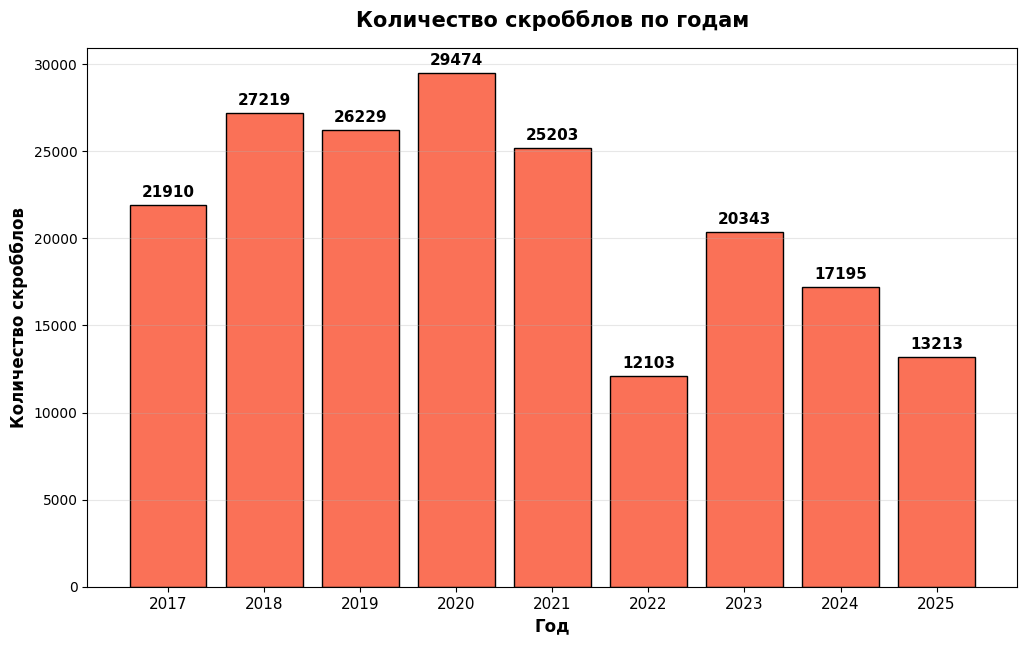

In [15]:
import matplotlib.pyplot as plt

year_values = {}
    
for scrobble in Scrobble._scrobbles:
    year = scrobble.date.year
    year_values[year] = year_values.get(year, 0) + 1

sorted_years = sorted(year_values.items())
years = [year for year, _ in sorted_years]
values = [value for _, value in sorted_years]
    
plt.figure(figsize=(12, 7))
    
bars = plt.bar(range(len(years)), values, color='#FA7157', edgecolor='black')
    
for i, (bar, count) in enumerate(zip(bars, values)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01, count,
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
plt.xticks(range(len(years)), [year for year in years], fontsize=11)
plt.yticks(fontsize=10)
    
plt.title(f'Количество скробблов по годам', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Год', fontsize=12, fontweight='bold')
plt.ylabel('Количество скробблов', fontsize=12, fontweight='bold')
    
plt.grid(axis='y', alpha=0.3)
plt.rcParams['axes.axisbelow'] = True

plt.show()

Самый «продуктивный» год в плане прослушивания музыки был 2020-й. Построим тепловую карту по количеству скробблов в день в 2020 году:

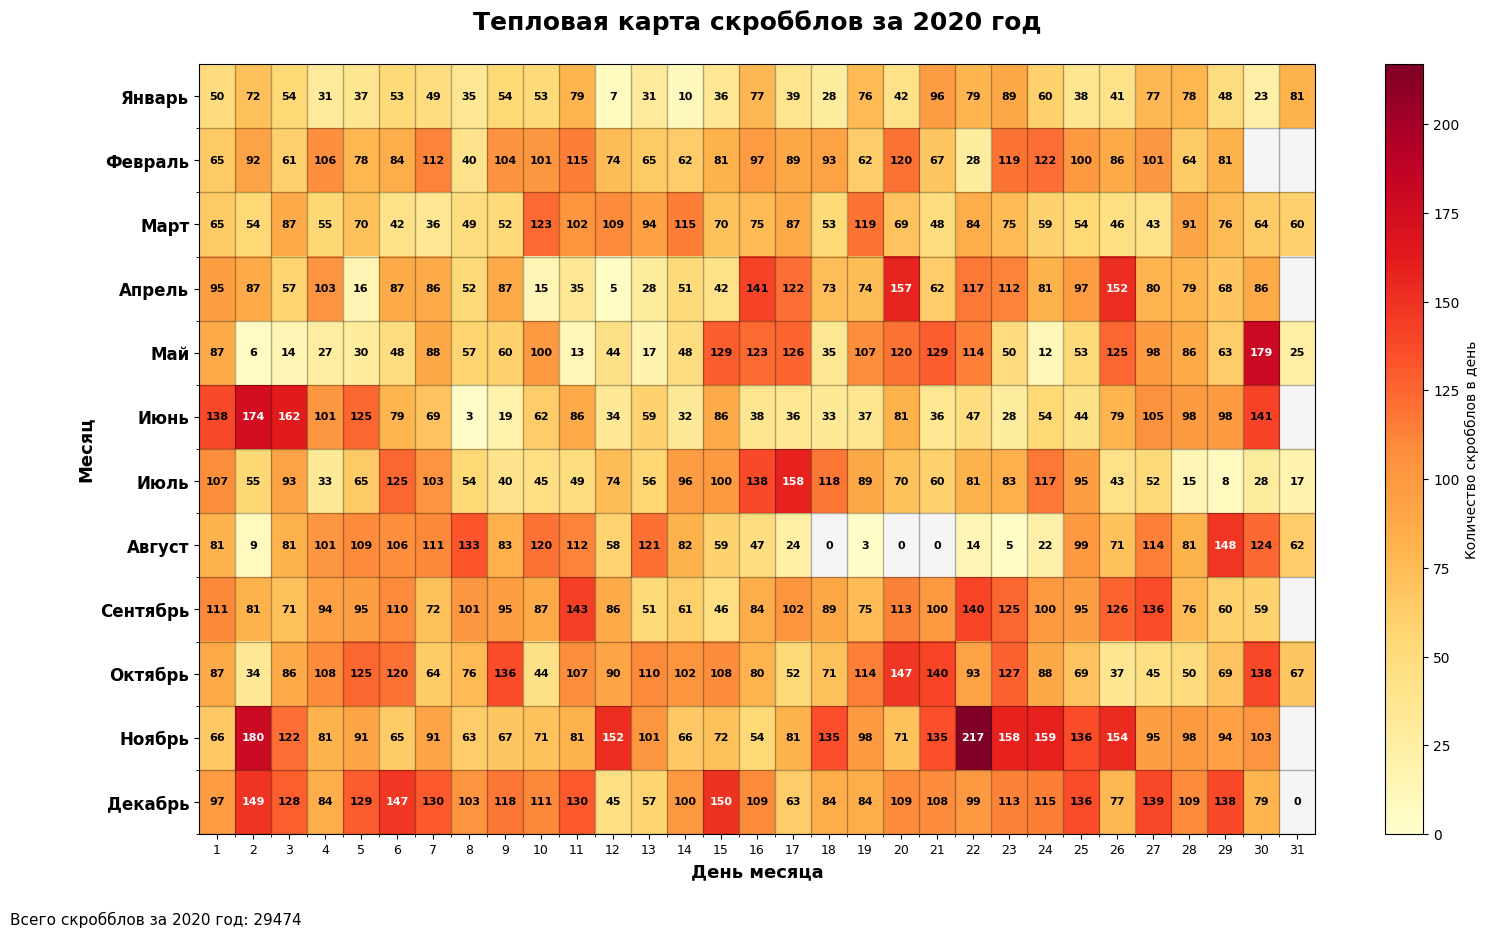

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import calendar
from datetime import datetime

scrobbles_2020 = []
for scrobble in Scrobble._scrobbles:
    if scrobble.date.year == 2020:
        scrobbles_2020.append(scrobble)

days_in_months = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] #список из количества дней в каждом месяце

heatmap_by_month = []

for month in range(1, 13): 
    days_in_month = days_in_months[month-1]
    month_data = [0] * days_in_month #для каждого месяца добавляем столько 0, сколько в нем дней
    heatmap_by_month.append(month_data)

for scrobble in scrobbles_2020:
    month = scrobble.date.month - 1  
    day = scrobble.date.day - 1      
    
    if day < len(heatmap_by_month[month]):
        heatmap_by_month[month][day] += 1 #заполняем данные по каждому дню


max_days = 31 
heatmap_data = np.zeros((12, max_days)) * np.nan  #делаем шаблон для тепловой карты; 
#заполнение шаблона с помощью NaN позволит красиво отобразить на тепловой карте дни, которых нет в месяце (например, 30 февраля)

for month_index in range(12):
    days_num = days_in_months[month_index]
    for day_index in range(days_num):
        scrobble_count = heatmap_by_month[month_index][day_index]
        heatmap_data[month_index, day_index] = scrobble_count #заполняем данные тепловой карты

month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

fig, ax = plt.subplots(figsize=(18, 10))

cmap = plt.cm.YlOrRd #берем тепловую карту "желтый, оранжевый, красный", где по мере увеличения значения цветовая гамма идет от желтого к красному
cmap.set_bad('#F2F2F2', alpha=0.7)  #у тех дней, где значение NaN, будет светло-серый цвет
 
heatmap_data[heatmap_data == 0] = np.nan #сделаем так, чтобы дни со значением 0 окрашивались так же, как и "несуществубщие дни"
image = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest', vmin=0) #строим тепловую карту

#подписываем оси
ax.set_xticks(range(max_days))
ax.set_xticklabels([str(i+1) for i in range(max_days)], fontsize=9)
ax.set_yticks(range(12))
ax.set_yticklabels(month_names, fontsize=12, fontweight='bold')

#добавляем сетку
ax.set_xticks([x - 0.5 for x in range(1, max_days)], minor=True)
ax.set_yticks([y - 0.5 for y in range(1, 13)], minor=True)
ax.grid(which='minor', color='black', linewidth=1, alpha=0.3)

#ищем максимальное значение для того, чтобы настроить цвет текста в тепловой карте
max_value = 0
for month_index in range(12):
    for day_index in range(days_in_months[month_index]):
        value = heatmap_by_month[month_index][day_index]
        max_value = max(max_value, value)

#добавляем значения в ячейки
for month_index in range(12):
    for day_index in range(days_in_months[month_index]):
        value = heatmap_by_month[month_index][day_index]
        if value >= 0:
            text_color = 'black' if value < max_value/1.5 else 'white'
            ax.text(day_index, month_index, value, ha='center', va='center', 
                    color=text_color, fontsize=8, fontweight='bold')

ax.set_title('Тепловая карта скробблов за 2020 год', 
              fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel('День месяца', fontsize=13, fontweight='bold')
ax.set_ylabel('Месяц', fontsize=13, fontweight='bold')

plt.colorbar(image, ax=ax, label='Количество скробблов в день')

total_scrobbles = len(scrobbles_2020)

total_text = f'Всего скробблов за 2020 год: {total_scrobbles:}'
fig.text(0.02, 0.02, total_text, fontsize=11) #добавляем текст с общим числов скробблов за год

plt.show()